# Time Series Motifs
Are approximate repeated subsequences in time series. There's been plenty of work on `motif discovery` — I outlined one of those approaches [here](../../papers/probabilistic_discovery_of_time_series_motifs.ipynb).

This notebook is focused on introducing `time series motifs`, and using the most basic algorithm to discover them.

2019-05-21 09:51:00 2019-07-07 11:08:00


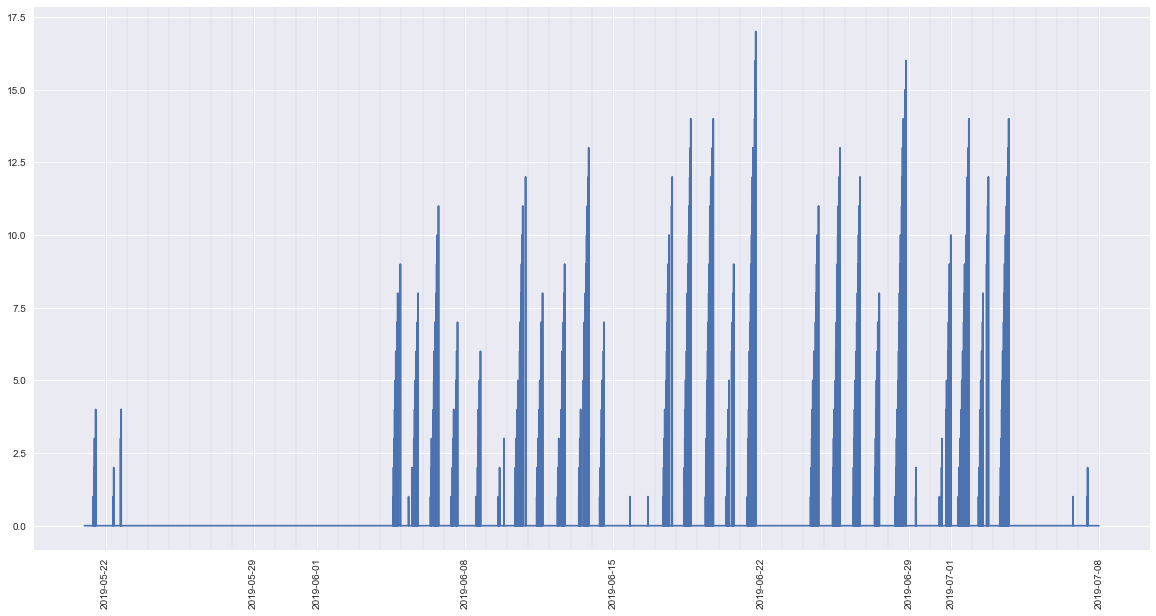

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime   
import seaborn as sns
import matplotlib.pyplot as plt
import logging

plt.style.use('seaborn')

df_raw = pd.read_csv("~/data/all_pomodoros.bsv", )
df_raw["time"] = pd.to_datetime(df_raw["time"])
min_date, max_date = df_raw["time"].min(), df_raw["time"].max()
print(min_date, max_date)
df_range = pd.date_range(min_date.floor('d'), max_date.ceil('d'), freq='min').to_frame()
df_range.columns = ["time"]
df_ts = pd.merge(df_range, df_raw, on="time", how="left")
df_ts["value"].fillna(0, inplace=True)
df_ts.set_index("time", inplace=True)
plt.figure(figsize=(20, 10))

try:
    for day in df_ts.iloc[w_i].index:
        plt.axvline(x=day, alpha=0.05)
except:
    logging.warn("run entire notebook to get w_i")
plt.xticks(rotation=90)
plt.plot(df_ts);

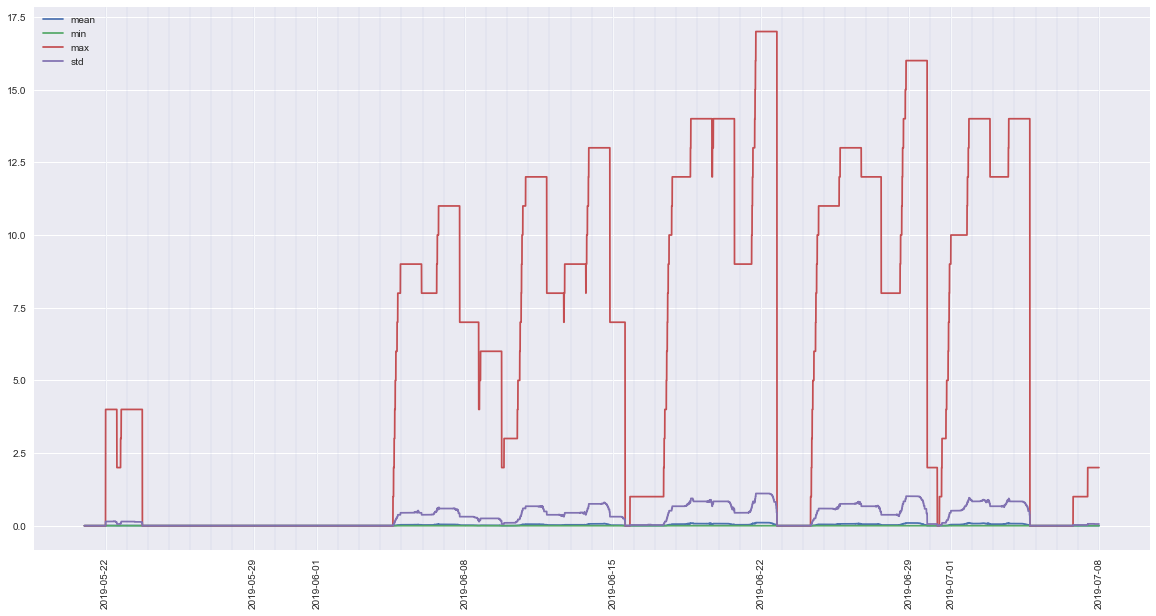

In [7]:
expanded = []
def expand(df, w):
    w = df.rolling(w)
    df_w =  pd.concat([w.mean(), w.min(), w.max(), w.std()], 
                      axis=1)
    df_w.columns = ["mean", "min", "max", "std"]
    return df_w.fillna(0)
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

w = 60 * 24
df_expanded = expand(df_ts, w)

plt.plot(df_expanded["mean"])
plt.plot(df_expanded["min"])
plt.plot(df_expanded["max"])
plt.plot(df_expanded["std"])

try:
    for day in df_expanded.iloc[w_i].index:
        plt.axvline(x=day, alpha=0.05)
except:
    logging.warn("run entire notebook to get w_i")

plt.legend();

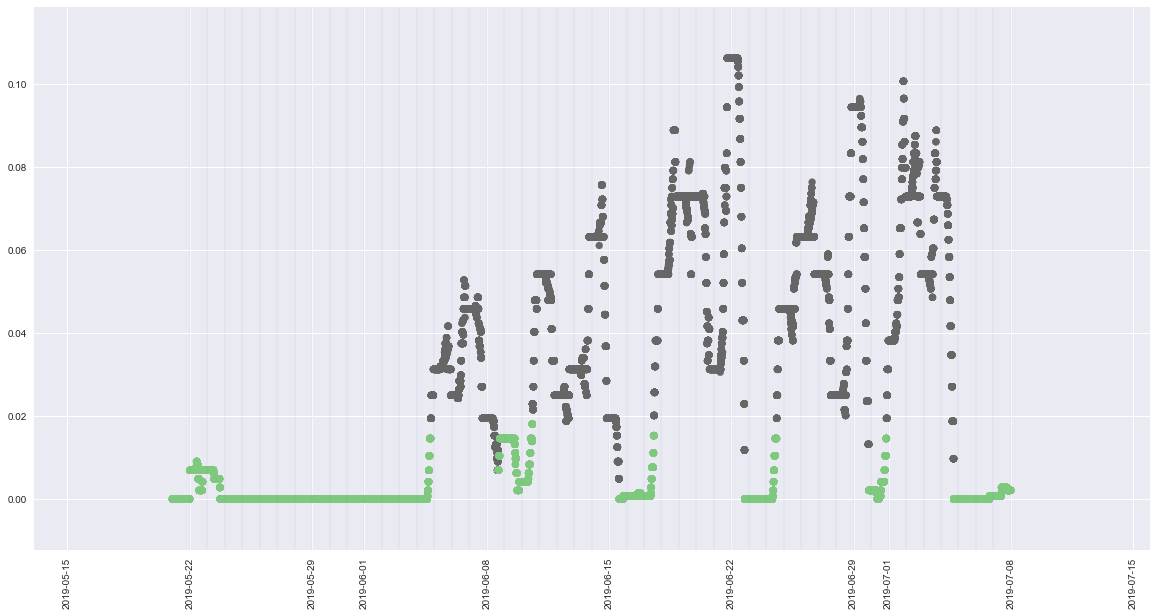

In [8]:
from sklearn.cluster import KMeans

cls = KMeans(n_clusters=2)
cls.fit(df_expanded[["mean", "min", "max", "std"]])

labels = cls.predict(df_expanded[["mean", "min", "max", "std"]])
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

try:
    for day in df_expanded.iloc[w_i].index:
        plt.axvline(x=day, alpha=0.05)
except:
    logging.warn("run entire notebook to get w_i")

plt.scatter(df_expanded.index, df_expanded["mean"], c=labels, cmap="Accent");

In [9]:
w_i = np.arange(w, labels.shape[0], w)
w_labels = labels[w_i]
window_labels = np.append(np.array([0]), np.ravel([[label]*w for label in w_labels]))

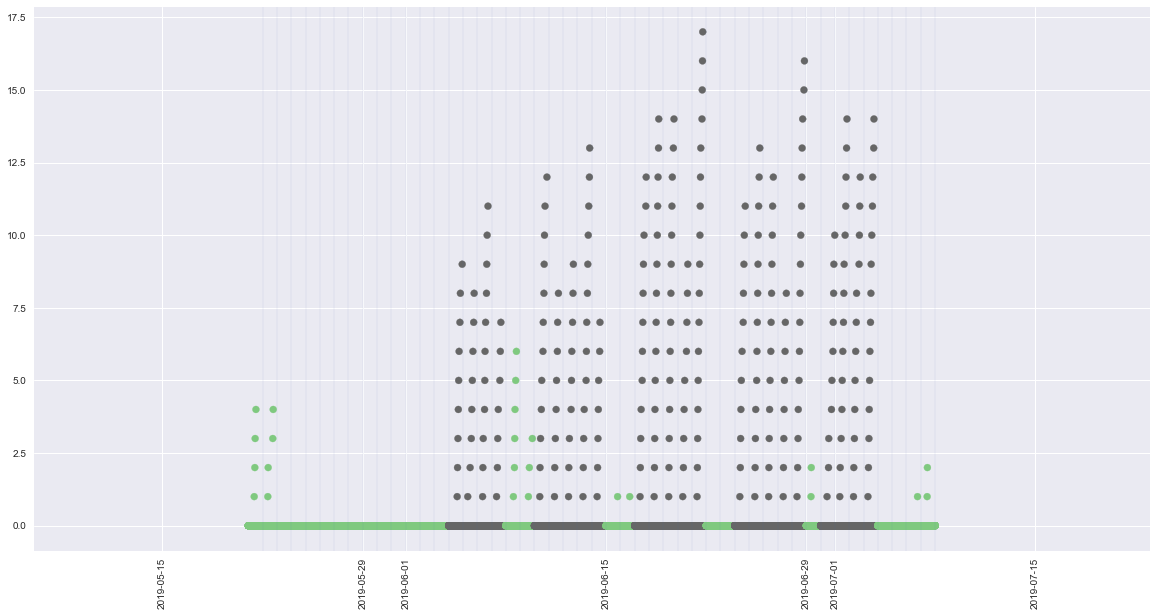

In [10]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.scatter(df_ts.index, df_ts["value"], c=window_labels, cmap="Accent");

for day in df_ts.iloc[w_i].index:
    plt.axvline(x=day, alpha=0.05)

## Exploring other methods

motif location: 0 to 125
motif location: 16666 to 16791
motif location: 33332 to 33457


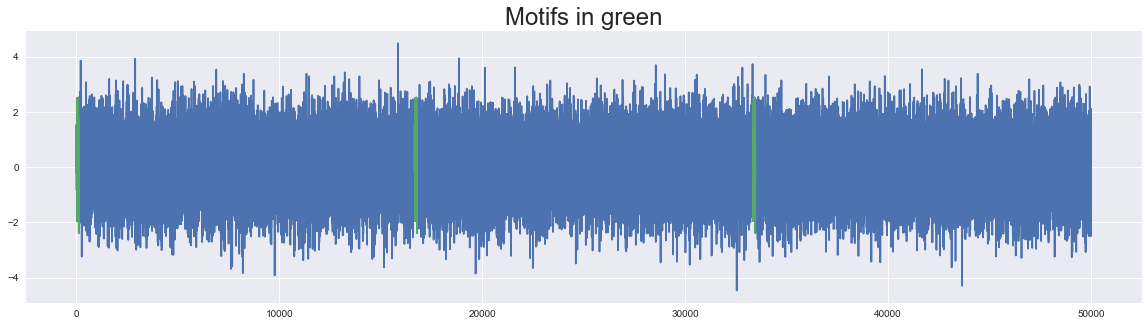

In [3]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')
%matplotlib inline

n_samples, window_size, n_segments, n_symbols = 50000, 6, 200 // 6, 8
rng = np.random.RandomState(42)
X = rng.randn(n_samples)

motif_size, n_motifs = 125, 3
motif = rng.randn(motif_size)

point = n_samples // n_motifs
motifs = np.zeros(X.shape[0])
motifs[:] = np.nan

motif_starts = []
for i in range(n_motifs):
    motifs[i*point: i*point + motif_size] = motif
    X[i*point: i*point + motif_size] = motif
    print(f"motif location: {i*point} to {i*point + motif_size}")
    
    motif_starts.append(i*point)

plt.figure(figsize=(20, 5))
plt.plot(X)
plt.plot(motifs)
plt.title("Motifs in green", fontsize=24);

## Comparing methods

In [10]:
from sklearn.random_projection import GaussianRandomProjection
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

n_samples, n_segments, motif_size = len(X), 10, 125

def implants_equal(arr):
    return (arr[motif_starts[0], :] == arr[motif_starts[1], :]).all() \
        and (arr[motif_starts[2], :] == arr[motif_starts[0], :]).all()

### First approach

Use `symbolic aggregate approximation` to discretize the time series. This is slow, but gives us a discrete version of the time series which can be paired with `min hashing` or something similar.

In [11]:
%%time
n_symbols = 4
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=n_symbols)
S = np.zeros((n_samples-motif_size+1, n_segments))

for i in range(n_samples-motif_size+1):
    S[i, :] = sax.fit_transform(X[i:i+motif_size]).ravel()

print(S.shape)
assert implants_equal(S)

(49876, 10)
CPU times: user 7.26 s, sys: 30.3 ms, total: 7.29 s
Wall time: 7.28 s


### Second Approach

Use `random projection` to reduce the dimensionality. It's fast.

In [27]:
%%time
n_components = 10

paa = PiecewiseAggregateApproximation(n_segments=n_segments)
S = np.zeros((n_samples-motif_size+1, motif_size))

grp = GaussianRandomProjection(n_components=n_components)

for i in range(n_samples-motif_size+1):
    S[i, :] = X[i:i+motif_size].ravel()
S_new = grp.fit_transform(S)

print(S_new.shape)
assert implants_equal(S_new)

(49876, 10)
CPU times: user 88.4 ms, sys: 5.13 ms, total: 93.5 ms
Wall time: 75.7 ms


How long do it take to calculate all `euclidean distances`?

In [38]:
%%time
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(S, S)

CPU times: user 1min 19s, sys: 1min 4s, total: 2min 24s
Wall time: 2min 42s


What about `cosine similarity`?

In [14]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(S, S)

CPU times: user 51.5 s, sys: 35 s, total: 1min 26s
Wall time: 1min 36s


In [ ]:
%%time
thresh = 0.9
row_idx = np.where(np.sum(dist, axis=1) > 0)

r, cols = np.where(np.sum(dist[row_idx, :], axis=0) > thresh)

row_dict = dict(zip(range(len(row_idx[0])), row_idx[0]))
rows = [row_dict[i] for i in r]

indices = set([])

for r, c in zip(rows, cols):
    if r != c and abs(r - c) > motif_size * 2:
        element = (r, c, dist[r, c])
        indices.add(element)
    
sorted(indices, key=lambda x: x[0])[:10]

### Third Approach

In [52]:
%%time
n_components = 24
n_symbols = 8

Y = np.zeros((n_samples-motif_size+1, motif_size))
S = np.zeros((n_samples-motif_size+1, n_components))

sax = SymbolicAggregateApproximation(n_segments=n_components, alphabet_size_avg=n_symbols)

grp = GaussianRandomProjection(n_components=n_components)

for i in range(n_samples-motif_size+1):
    Y[i, :] = X[i:i+motif_size].ravel()
    
Y_new = grp.fit_transform(S)

for j in range(n_samples-motif_size+1):
    S[i, :] = sax.fit_transform(Y_new[i, :]).ravel()

print(S.shape)
assert implants_equal(S)

(49876, 24)
CPU times: user 15.7 s, sys: 173 ms, total: 15.9 s
Wall time: 15.5 s


In [55]:
np.sum(S)

3739786.0

In [107]:
(S_new[0, :], S_new[400, :])

(array([ 0.18089822, -0.87576609,  0.33034393, -0.25919735]),
 array([ 0.18089822, -0.87576609,  0.33034393, -0.25919735]))